In [1]:

import os
import larq as lq
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

import templates

In [2]:
# Helper functions
def print_image(image):
  # Squeeze the third dimension or you can use indexing to select the first slice
  image_2d = np.squeeze(image)

  # Plotting the image
  plt.imshow(image_2d, cmap='gray')  # Use the gray colormap for grayscale
  plt.colorbar()  # Optionally add a colorbar to see the intensity scale
  plt.show()

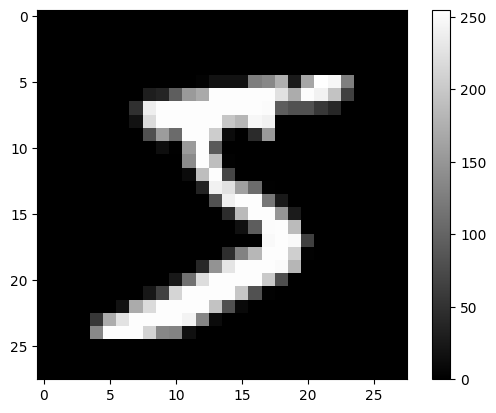

In [3]:
# Prepare dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))

print_image(train_images[0])
# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

In [4]:
class InputShapeCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.input_shapes = []

    def on_epoch_end(self, epoch, logs=None):
        
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.BatchNormalization):
                input_shape = layer.input_shape
                self.input_shapes.append((layer.name, input_shape))
                print(f"Layer: {layer.name}, Input shape: {input_shape}")

In [5]:
# NN Topology

kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip")

model = tf.keras.models.Sequential()

input_shape = (28, 28, 1) # Input img shape
filters_a = 32 # Number of output channels
kernel_three = (4, 4) # Kernel dimension

filters_b = 32 # Number of output channels
kernel_b = (3, 3) # Kernel dimension

model.add(lq.layers.QuantConv2D(filters_a, kernel_three,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantConv2D(filters_b, kernel_b,
                                input_quantizer="ste_sign",
                                kernel_quantizer="ste_sign",
                                kernel_constraint="weight_clip",
                                use_bias=False,
                                input_shape=input_shape))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Flatten())
model.add(lq.layers.QuantDense(128, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
model.add(tf.keras.layers.BatchNormalization(scale=False))
model.add(tf.keras.layers.Activation("softmax"))
# model.add(tf.keras.layers.Flatten())
# # model.add(lq.layers.QuantDense(500, use_bias=False, **kwargs))
# model.add(lq.layers.QuantDense(10, use_bias=False, **kwargs))
# model.add(tf.keras.layers.Activation("softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, batch_size=64, epochs=6)

Epoch 1/6
938/938 [==============================] - 18s 19ms/step - loss: 0.6544 - accuracy: 0.9087
Epoch 2/6
938/938 [==============================] - 17s 18ms/step - loss: 0.5002 - accuracy: 0.9567
Epoch 3/6
938/938 [==============================] - 16s 17ms/step - loss: 0.4765 - accuracy: 0.9638
Epoch 4/6
938/938 [==============================] - 16s 17ms/step - loss: 0.4641 - accuracy: 0.9679
Epoch 5/6
938/938 [==============================] - 16s 17ms/step - loss: 0.4588 - accuracy: 0.9691
Epoch 6/6
938/938 [==============================] - 17s 18ms/step - loss: 0.4560 - accuracy: 0.9704


In [6]:
# Train NN
test_loss, test_acc = model.evaluate(test_images, test_labels)
lq.models.summary(model)

313/313 [==============================] - 2s 4ms/step - loss: 0.4991 - accuracy: 0.9654
+sequential stats-----------------------------------------------------------------------------+
| Layer                  Input prec.           Outputs  # 1-bit  # 32-bit  Memory  1-bit MACs |
|                              (bit)                        x 1       x 1    (kB)             |
+---------------------------------------------------------------------------------------------+
| quant_conv2d                     1  (-1, 25, 25, 32)      512         0    0.06      320000 |
| max_pooling2d                    -  (-1, 12, 12, 32)        0         0       0           0 |
| batch_normalization              -  (-1, 12, 12, 32)        0        64    0.25           0 |
| quant_conv2d_1                   1  (-1, 10, 10, 32)     9216         0    1.12      921600 |
| max_pooling2d_1                  -    (-1, 5, 5, 32)        0         0       0           0 |
| batch_normalization_1            -    (-1, 5,

In [7]:
# # Extract weights
# with lq.context.quantized_scope(True):
#     weights = model.layers[3].get_weights()
#     print(weights)

#     if len(weights) > 0:
#         weight_array = weights[0] 
#         print("Weights shape:", weight_array.shape)
#     else:
#         print("No weights found in this layer.")

# print(weights[0].shape)
# rows, cols, _, output_channels = weights[0].shape
# print(rows, cols, output_channels)
# for col in range(cols):
#     for row in range(rows):
#         for output_channel in range(output_channels):
#             print(row, col, output_channel, weights[0][row][col][0][output_channel])

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        print(f"Layer: {layer.name}")
        print(f"  Beta (offset): {beta}")
        print(f"Beta Length: {len(beta)}")
        print(f"  Moving Mean: {moving_mean}")
        print(f" Moving Mean Length: {len(moving_mean)}")
        print(f"  Moving Variance: {moving_variance}")
        print(f"  Moving Variance Length: {len(moving_variance)}")

Layer: batch_normalization
  Beta (offset): [-1.21813387e-01 -1.74739093e-01 -3.27783704e-01  3.53027374e-01
 -1.09255242e+00 -4.05520260e-01  1.23358555e-01 -5.96586466e-01
 -3.25887538e-02 -3.79818141e-01 -5.47126353e-01 -2.57174820e-01
 -6.04369998e-01 -2.64586866e-01 -1.79705843e-01 -3.04063648e-01
 -4.31858480e-01 -3.76465261e-01 -1.59128517e-01 -6.15197718e-01
 -8.05432796e-02 -1.32059276e-01 -2.39873856e-01 -1.01554184e-03
 -2.99865395e-01 -2.93905109e-01 -3.60132843e-01 -1.85029775e-01
 -2.78929770e-01 -1.63783237e-01 -3.55082840e-01 -5.18926561e-01]
Beta Length: 32
  Moving Mean: [ 3.460862   -0.71490407  2.9112906  -1.381075    1.9508567   0.7135684
 -0.93062854  5.286661   -2.8647237   3.2657008   4.2312403   6.22665
  3.9604487   4.159044   -2.6283598   5.67221     3.1019099   6.096448
  1.1206907   5.7346344  -3.0208535  -1.7929711   4.122885    1.578727
  6.0405884   4.480065   -2.8120716   0.5694792   3.9332128   1.0884994
  6.2638574   3.731975  ]
 Moving Mean Length: 3

In [8]:
input_shape_callback = InputShapeCallback()

for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        input_shape = layer.input_shape
        print(f"Layer: {layer.name}, Input shape: {input_shape}")

Layer: batch_normalization, Input shape: (None, 12, 12, 32)
Layer: batch_normalization_1, Input shape: (None, 5, 5, 32)
Layer: batch_normalization_2, Input shape: (None, 128)
Layer: batch_normalization_3, Input shape: (None, 10)


In [9]:
if not os.path.exists("gen_hdl"):
    os.mkdir("gen_hdl")

# Extract weights
betas = []
moving_means = []
moving_variances = []
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        beta, moving_mean, moving_variance = layer.get_weights()
        betas.append(beta)
        moving_means.append(moving_mean)
        moving_variances.append(moving_variance)

In [10]:
def parse_bn(beta, moving_mean, moving_variance, num: int):

    # thresholds = np.zeros(len(beta))
    compare = ""
    for output_neuron in range(len(beta)):
        # print(len(beta))
        threshold = moving_mean[output_neuron] - beta[output_neuron] * np.sqrt(moving_variance[output_neuron])
        compare += f"   assign o_data[{output_neuron}] = i_data[{output_neuron}] > {threshold} ? 1 : 0;\n"

    output_hdl = templates.BN_TEMPLATE \
        .replace("%DIM_DATA%", str(len(beta))) \
        .replace("%LAYER_NUM%", str(num)) \
        .replace("%COMPARE%", compare)
        
    with open(f"gen_hdl/bn_layer_{num}.v", "w") as f:
        f.write(output_hdl)

In [11]:
for n in range(len(betas)):
    parse_bn(betas[n], moving_means[n], moving_variances[n], n)
